## Introduction

* This project aims to find a good place to open a Chinese restaurant in Manhattan city.we are going to get data from the this linkage: https://geo.nyu.edu/catalog/nyu_2451_34572 . we are going to utilize the Foursquare API to explore the neighborhoods and gain data of venues. The top 100 venues of neighbors within a radius of 500 meters will be obtained.
* we will explore restaurant in Manhattan. Communities of Manhattan will be clustered by k-mean clustering. 
* Based on clusters and what we analyzed before, Recommendation will be given where is suitable for starting Chinese Restaurant business.

##### Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Manhattan</a>   
    
3. <a href="#item3">Explore Restaurant in Manhattan</a>
    
4. <a href="#item3">Analyze Each Neighborhood</a>

5. <a href="#item4">Cluster Neighborhoods</a>

6. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 


# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [11]:
print('Manhattan has {} neighborhoods.'.format(manhattan_data.shape[0]))

Manhattan has 40 neighborhoods.


#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = '40RKQ0YR25WMDEQL2AY3OZODZMOLVMV3NLNG5TAJ3X0JWP5K' # your Foursquare ID
CLIENT_SECRET = 'BIVJ5YAKNUMUDW4GGOBB2Z3KHGB5DB1ATANOIJCFHTET4RHW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 40RKQ0YR25WMDEQL2AY3OZODZMOLVMV3NLNG5TAJ3X0JWP5K
CLIENT_SECRET:BIVJ5YAKNUMUDW4GGOBB2Z3KHGB5DB1ATANOIJCFHTET4RHW


<a id='item2'></a>

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to explore venues of all the neighborhoods in Manhattan

In [13]:
LIMIT=100  

def getNearbyVenues(names, latitudes, longitudes, radius=500): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [14]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Check dataset we got,especially the column of Venue Category. Let's find out how many unique categories can be curated from all the returned venues

In [15]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3320, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [98]:
#check how mang shops on Neighborhood's venues
manhattan_shops=manhattan_venues.groupby('Neighborhood').count()
manhattan_shops.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,99,99,99,99,99,99
Carnegie Hill,100,100,100,100,100,100
Central Harlem,46,46,46,46,46,46
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100


In [146]:
print('There are {} unique categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 333 unique categories.


In [150]:
print('There are {} shops in total'.format(manhattan_shops['Venue Category'].sum(),axis=0))

There are 3320 shops in total


## 3. Explore Restaurants in Manhattan

#### 3.1 Let's see how many restaurants in Manhattan and its distribution

In [95]:
#select category is dinner
manhattan_restaurant1=manhattan_venues[manhattan_venues['Venue Category'].str.contains('Diner')]

#select restaurant
manhattan_restaurant2=manhattan_venues[manhattan_venues['Venue Category'].str.contains('Restaurant')]

#total restaurant in Manhattan
total_manhattan_restaurant=manhattan_restaurant1.append(manhattan_restaurant2)
total_manhattan_restaurant=manhattan_restaurant.groupby('Neighborhood').count()

In [96]:
#prepare dataset suitable for bar plotting
total_manhattan_restaurant.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude'],axis=1,inplace=True)
total_manhattan_restaurant.sort_values('Venue Category',inplace=True,ascending=False)
total_manhattan_restaurant.head()

,Venue Category
Neighborhood,
Greenwich Village,44
Chinatown,44
Upper West Side,38
East Village,38
Murray Hill,37


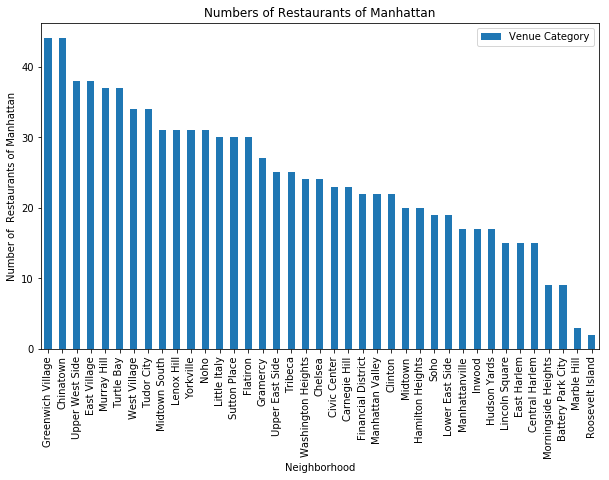

In [151]:
#create bar of restaurants of Manhattan
total_manhattan_restaurant.plot(kind='bar', figsize=(10, 6))
plt.title('Numbers of Restaurants of Manhattan')
plt.ylabel('Number of  Restaurants of Manhattan')
plt.xlabel('Neighborhood')

plt.show()

#### 3.2 Calculate Restaurant's percentage of each Neighborhood.

In [105]:
# merge total_manhattan_restaurant and manhattan_shops dataset
Percentage_restaurant=pd.merge(total_manhattan_restaurant,manhattan_shops,on='Neighborhood',how='inner')
Percentage_restaurant.head()

,Venue Category_x,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category_y
Neighborhood,,,,,,,
Greenwich Village,44,100,100,100,100,100,100
Chinatown,44,100,100,100,100,100,100
Upper West Side,38,100,100,100,100,100,100
East Village,38,100,100,100,100,100,100
Murray Hill,37,100,100,100,100,100,100


In [108]:
Percentage_restaurant.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude'],axis=1, inplace=True)
Percentage_restaurant.head()

,Venue Category_x,Venue Category_y
Neighborhood,,
Greenwich Village,44,100
Chinatown,44,100
Upper West Side,38,100
East Village,38,100
Murray Hill,37,100


In [139]:
#reset index
Percentage_restaurant2=Percentage_restaurant.reset_index()
Percentage_restaurant2.head()

,Neighborhood,Venue Category_x,Total_number_shop
0,Greenwich Village,44,100
1,Chinatown,44,100
2,Upper West Side,38,100
3,East Village,38,100
4,Murray Hill,37,100


In [123]:
#check datatype
Percentage_restaurant2.dtypes

Neighborhood         object
Venue Category_x      int64
Total_number_shop     int64
dtype: object

In [140]:
#calculate percentage of restaurant of each neighborhood
Percentage_restaurant2['Percentage']=Percentage_restaurant2.apply(lambda x:x['Venue Category_x']/x['Total_number_shop'],axis=1)
Percentage_restaurant2.head()

,Neighborhood,Venue Category_x,Total_number_shop,Percentage
0,Greenwich Village,44,100,0.44
1,Chinatown,44,100,0.44
2,Upper West Side,38,100,0.38
3,East Village,38,100,0.38
4,Murray Hill,37,100,0.37


In [141]:
Percentage_restaurant2.drop(['Venue Category_x','Total_number_shop'],axis=1,inplace=True)
Percentage_restaurant2=Percentage_restaurant2.set_index('Neighborhood')

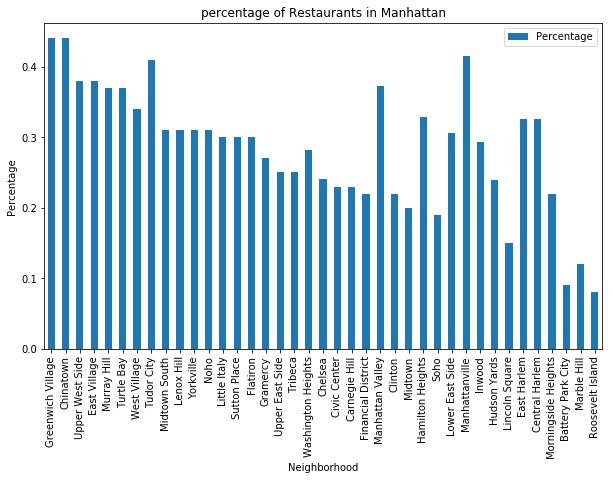

In [152]:
#create bar for percentages of restaurants in Manhattan
Percentage_restaurant2.plot(kind='bar', figsize=(10, 6))
plt.title('percentage of Restaurants in Manhattan')
plt.ylabel('Percentage')
plt.xlabel('Neighborhood')

plt.show()

#### 3.3 Let's see how many Chinese restaurants in Manhattan and its distribution

**If you check the dataset 'total_manhattan_restaurant', you will see Chinese restaurant in the column of Veune Category were marked as Chinese Restaurant, Shanghai Restaurant, Dim Sum Restaurant, Hotpot Restaurant and Dumpling Restaurant. So we are going to extract dataset of five kinds of restaurants. Then, five dataset will be merged together to get a whole picture of Chinese restaurants in Manhattan.**

In [155]:
#select Chinese restaurant 
chinese_restaurant1=manhattan_restaurant2[manhattan_restaurant2['Venue Category']=='Chinese Restaurant']
chinese_restaurant1.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
25,Chinatown,40.715618,-73.994279,Spicy Village,40.717010,-73.993530,Chinese Restaurant
36,Chinatown,40.715618,-73.994279,Wah Fung Number 1 Fast Food 華豐快飯店,40.717278,-73.994177,Chinese Restaurant
47,Chinatown,40.715618,-73.994279,Xi'an Famous Foods,40.715232,-73.997263,Chinese Restaurant
55,Chinatown,40.715618,-73.994279,Great N.Y. Noodletown,40.715039,-73.996941,Chinese Restaurant
63,Chinatown,40.715618,-73.994279,Joe's Shanghai 鹿嗚春,40.714692,-73.997701,Chinese Restaurant


In [156]:
print('There are {} Chinese Restaurants in Manhatton' .format(chinese_restaurant1.shape[0]))

There are 50 Chinese Restaurants in Manhatton


In [157]:
chinese_restaurant1.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,1,1,1,1,1,1
Central Harlem,3,3,3,3,3,3
Chelsea,1,1,1,1,1,1
Chinatown,10,10,10,10,10,10
Clinton,1,1,1,1,1,1
East Harlem,1,1,1,1,1,1
East Village,3,3,3,3,3,3
Flatiron,1,1,1,1,1,1
Greenwich Village,2,2,2,2,2,2


In [158]:
#select Shanghai restaurant 
chinese_restaurant2=manhattan_restaurant2[manhattan_restaurant2['Venue Category']=='Shanghai Restaurant']
chinese_restaurant2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
100,Chinatown,40.715618,-73.994279,Shanghai Asian Cuisine • 上海小館,40.715918,-73.997311,Shanghai Restaurant
1202,Murray Hill,40.748303,-73.978332,Little Alley,40.747326,-73.977016,Shanghai Restaurant
3088,Tudor City,40.746917,-73.971219,Little Alley,40.747326,-73.977016,Shanghai Restaurant


In [159]:
print('There are {} Shanghai Restaurants in Manhatton' .format(chinese_restaurant2.shape[0]))

There are 3 Shanghai Restaurants in Manhatton


In [160]:
#select Dim Sum restaurant 
chinese_restaurant3=manhattan_restaurant2[manhattan_restaurant2['Venue Category']=='Dim Sum Restaurant']
chinese_restaurant3.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
56,Chinatown,40.715618,-73.994279,Jing Fong Restaurant 金豐大酒樓,40.715881,-73.997209,Dim Sum Restaurant
87,Chinatown,40.715618,-73.994279,Oriental Garden 福臨門海鮮酒家,40.715891,-73.997336,Dim Sum Restaurant
105,Chinatown,40.715618,-73.994279,Nom Wah Tea Parlor,40.714512,-73.998235,Dim Sum Restaurant
114,Chinatown,40.715618,-73.994279,Golden Unicorn Restaurant 麒麟金閣,40.713629,-73.997230,Dim Sum Restaurant
1067,Clinton,40.759101,-73.996119,Tim Ho Wan,40.759360,-73.991871,Dim Sum Restaurant


In [27]:
print('There are {} Dim Sum Restaurants in Manhatton' .format(chinese_restaurant3.shape[0]))

There are 5 Dim Sum Restaurants in Manhatton


In [161]:
#select Hotpot restaurant 
chinese_restaurant4=manhattan_restaurant2[manhattan_restaurant2['Venue Category']=='Hotpot Restaurant']
chinese_restaurant4.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
54,Chinatown,40.715618,-73.994279,Little Sheep Mongolian Hot Pot,40.717639,-73.995187,Hotpot Restaurant
75,Chinatown,40.715618,-73.994279,99 Favor Taste 99號餐廳,40.717560,-73.992580,Hotpot Restaurant
80,Chinatown,40.715618,-73.994279,Hou Yi Hot Pot,40.716374,-73.992509,Hotpot Restaurant


In [29]:
print('There are {} Hotpot Restaurants in Manhatton' .format(chinese_restaurant4.shape[0]))

There are 3 Hotpot Restaurants in Manhatton


In [162]:
#select Dumpling restaurant 
chinese_restaurant5=manhattan_restaurant2[manhattan_restaurant2['Venue Category']=='Dumpling Restaurant']
chinese_restaurant5.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
92,Chinatown,40.715618,-73.994279,Vanessa's Dumpling House,40.718316,-73.991885,Dumpling Restaurant
117,Chinatown,40.715618,-73.994279,Shu Jiao Fu Zhou Cuisine 潭頭王福州小吃 (Shu Jiao Fu ...,40.718432,-73.991701,Dumpling Restaurant
121,Chinatown,40.715618,-73.994279,Shanghai Dumpling,40.717296,-73.997356,Dumpling Restaurant
344,Manhattanville,40.816934,-73.957385,La Salle Dumpling Room,40.814060,-73.959701,Dumpling Restaurant
1566,East Village,40.727847,-73.982226,Dumpling Man,40.727391,-73.984731,Dumpling Restaurant


In [31]:
print('There are {} Dumpling Restaurants in Manhatton' .format(chinese_restaurant5.shape[0]))

There are 6 Dumpling Restaurants in Manhatton


In [163]:
total_chinese_restaurant=chinese_restaurant1.append(chinese_restaurant2)
total_chinese_restaurant=total_chinese_restaurant.append(chinese_restaurant3)
total_chinese_restaurant=total_chinese_restaurant.append(chinese_restaurant4)
total_chinese_restaurant=total_chinese_restaurant.append(chinese_restaurant5)
total_chinese_restaurant=total_chinese_restaurant.groupby('Neighborhood').count().reset_index()
total_chinese_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Battery Park City,1,1,1,1,1,1
1,Central Harlem,3,3,3,3,3,3
2,Chelsea,1,1,1,1,1,1
3,Chinatown,21,21,21,21,21,21
4,Clinton,2,2,2,2,2,2


#### Plotting bar to show numbers of Chinese Restaurant in different neighbors of Manhattan


In [164]:
total_chinese_restaurant.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude'],axis=1,inplace=True)
total_chinese_restaurant.head()

,Neighborhood,Venue Category
0,Battery Park City,1
1,Central Harlem,3
2,Chelsea,1
3,Chinatown,21
4,Clinton,2


In [165]:
total_chinese_restaurant.set_index('Neighborhood',inplace=True)

In [166]:
total_chinese_restaurant.sort_values('Venue Category',inplace=True,ascending=False)
total_chinese_restaurant.head()

,Venue Category
Neighborhood,
Chinatown,21
East Village,4
Little Italy,4
Lower East Side,3
Central Harlem,3


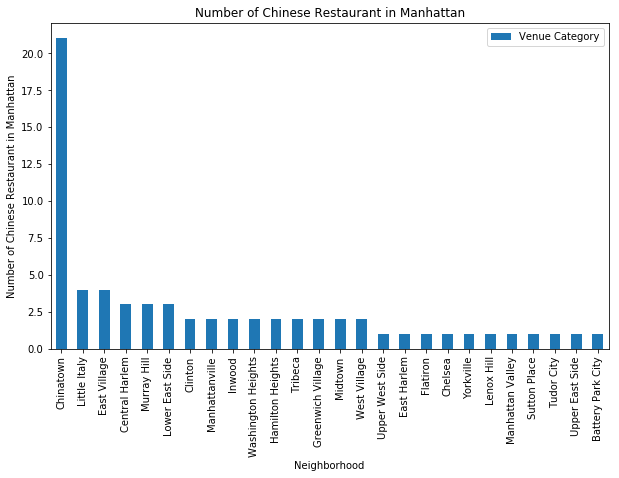

In [153]:
#create bar
total_chinese_restaurant.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Chinese Restaurant in Manhattan')
plt.ylabel('Number of Chinese Restaurant in Manhattan')
plt.xlabel('Neighborhood')

plt.show()

#### 3.4 Calculate percentage of Chinese restaurants of restaurant in each neighborhood of Manhattan

<a id='item3'></a>

In [168]:
per_chinese_restaurant=pd.merge(total_manhattan_restaurant,total_chinese_restaurant,on='Neighborhood',how='inner')
per_chinese_restaurant.head()

,Venue Category_x,Venue Category_y
Neighborhood,,
Greenwich Village,44,2
Chinatown,44,21
Upper West Side,38,1
East Village,38,4
Murray Hill,37,3


In [193]:
per_chinese_restaurant

,Venue Category_x,Venue Category_y
Neighborhood,,
Greenwich Village,44,2
Chinatown,44,21
Upper West Side,38,1
East Village,38,4
Murray Hill,37,3
West Village,34,2
Tudor City,34,1
Lenox Hill,31,1
Yorkville,31,1


In [195]:
per_chinese_restaurant2=per_chinese_restaurant.reset_index()

In [196]:
#calculate percentage of Chinese restaurant of all restaurants in each neighborhood
per_chinese_restaurant2['Percentage']=per_chinese_restaurant2.apply(lambda x:x['Venue Category_y']/x['Venue Category_x'],axis=1)
per_chinese_restaurant2.head()

,Neighborhood,Venue Category_x,Venue Category_y,Percentage
0,Greenwich Village,44,2,0.045455
1,Chinatown,44,21,0.477273
2,Upper West Side,38,1,0.026316
3,East Village,38,4,0.105263
4,Murray Hill,37,3,0.081081


In [189]:
per_chinese_restaurant2.drop(['Venue Category_x','Venue Category_y'],axis=1,inplace=True)
per_chinese_restaurant2.head()

,Neighborhood,Percentage
0,Greenwich Village,0.045455
1,Chinatown,0.477273
2,Upper West Side,0.026316
3,East Village,0.105263
4,Murray Hill,0.081081


In [201]:
list=['Washington Heights', 'Central Harlem', 'Midtown', 'Lower East Side', 'Little Italy', 'Soho', 'Flatiron','Chinatown']
df=per_chinese_restaurant2.loc[per_chinese_restaurant2['Neighborhood'].isin(list)]
df.rename(columns={'Venue Category_x':'number_of_restaurant','Venue Category_y':'number_of_Chinese_restaurant'},inplace=True)
df

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Neighborhood,number_of_restaurant,number_of_Chinese_restaurant,Percentage
1,Chinatown,44,21,0.477273
9,Little Italy,30,4,0.133333
11,Flatiron,30,1,0.033333
14,Washington Heights,24,2,0.083333
18,Midtown,20,2,0.100000
20,Lower East Side,19,3,0.157895
24,Central Harlem,15,3,0.200000


In [203]:
df.set_index('Neighborhood',inplace=True)
df

,number_of_restaurant,number_of_Chinese_restaurant,Percentage
Neighborhood,,,
Chinatown,44,21,0.477273
Little Italy,30,4,0.133333
Flatiron,30,1,0.033333
Washington Heights,24,2,0.083333
Midtown,20,2,0.100000
Lower East Side,19,3,0.157895
Central Harlem,15,3,0.200000


In [190]:
per_chinese_restaurant2=per_chinese_restaurant2.set_index('Neighborhood')

In [192]:
per_chinese_restaurant2

,Percentage
Neighborhood,
Greenwich Village,0.045455
Chinatown,0.477273
Upper West Side,0.026316
East Village,0.105263
Murray Hill,0.081081
West Village,0.058824
Tudor City,0.029412
Lenox Hill,0.032258
Yorkville,0.032258


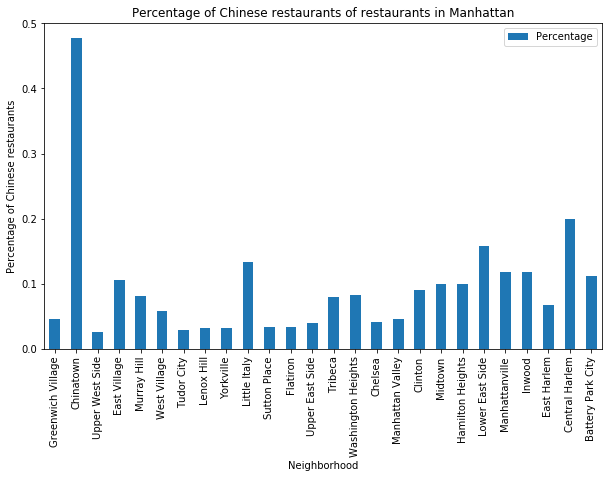

In [191]:
#create bar
per_chinese_restaurant2.plot(kind='bar', figsize=(10, 6))
plt.title('Percentage of Chinese restaurants of restaurants in Manhattan')
plt.ylabel('Percentage of Chinese restaurants')
plt.xlabel('Neighborhood')

plt.show()

## 4. Analyze Each Neighborhood

In [103]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

TypeError: 'numpy.ndarray' object is not callable

And let's examine the new dataframe size.

In [72]:
manhattan_onehot.shape

(3320, 334)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [104]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Ski Shop,Smoke Shop,Snack Plac

#### Let's confirm the new size

In [74]:
manhattan_grouped.shape

(40, 334)

#### Let's print each neighborhood along with the top 10 most common venues

In [97]:
num_top_venues = 10

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                venue  freq
0         Coffee Shop  0.07
1                Park  0.07
2               Hotel  0.05
3                 Gym  0.04
4       Shopping Mall  0.03
5           Wine Shop  0.03
6      Clothing Store  0.03
7  Italian Restaurant  0.03
8    Department Store  0.02
9       Boat or Ferry  0.02


----Carnegie Hill----
               venue  freq
0        Pizza Place  0.06
1        Coffee Shop  0.05
2                Bar  0.04
3               Café  0.04
4  French Restaurant  0.03
5                Gym  0.03
6                Spa  0.03
7     Cosmetics Shop  0.03
8          Bookstore  0.03
9          Wine Shop  0.03


----Central Harlem----
                  venue  freq
0    African Restaurant  0.07
1    Chinese Restaurant  0.07
2            Public Art  0.04
3   American Restaurant  0.04
4  Gym / Fitness Center  0.04
5        Cosmetics Shop  0.04
6     French Restaurant  0.04
7    Seafood Restaurant  0.04
8    Salon / Barbershop  0.02
9             Cafete

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [105]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [106]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Gym,Shopping Mall,Wine Shop,Italian Restaurant,Clothing Store,Fountain,BBQ Joint
1,Carnegie Hill,Pizza Place,Coffee Shop,Café,Bar,Yoga Studio,Spa,French Restaurant,Grocery Store,Gym,Japanese Restaurant
2,Central Harlem,Chinese Restaurant,African Restaurant,American Restaurant,Cosmetics Shop,Public Art,French Restaurant,Seafood Restaurant,Gym / Fitness Center,Boutique,Bookstore
3,Chelsea,Coffee Shop,Ice Cream Shop,Italian Restaurant,Nightclub,Bakery,Seafood Restaurant,American Restaurant,Hotel,Theater,Market
4,Chinatown,Chinese Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Cocktail Bar,American Restaurant,Bar,Bakery,Noodle House,Hotpot Restaurant,Bubble Tea Shop


<a id='item4'></a>

## 5. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 10 clusters.

In [107]:
# set number of clusters
kclusters = 10

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([8, 7, 4, 0, 4, 0, 0, 2, 7, 8], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [108]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,9,Coffee Shop,Discount Store,Sandwich Place,Tennis Stadium,Gym,Big Box Store,Supplement Shop,Shoe Store,Seafood Restaurant,Yoga Studio
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Cocktail Bar,American Restaurant,Bar,Bakery,Noodle House,Hotpot Restaurant,Bubble Tea Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Latin American Restaurant,Mobile Phone Shop,Grocery Store,Deli / Bodega,Gym,Spanish Restaurant,Tapas Restaurant,Shoe Store
3,Manhattan,Inwood,40.867684,-73.921210,2,Mexican Restaurant,Lounge,Café,Pizza Place,Chinese Restaurant,Restaurant,Wine Bar,Bakery,Frozen Yogurt Shop,Park
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Mexican Restaurant,Pizza Place,Coffee Shop,Café,Yoga Studio,Bakery,Cocktail Bar,Sandwich Place,School,Chinese Restaurant


## 6. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [109]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Manhattan,Upper East Side,40.775639,-73.960508,0,Italian Restaurant,Coffee Shop,Exhibit,Bakery,Gym / Fitness Center,Art Gallery,Juice Bar,Cocktail Bar,French Restaurant,Spa
13,Manhattan,Lincoln Square,40.773529,-73.985338,0,Theater,Café,Concert Hall,Italian Restaurant,Gym / Fitness Center,Plaza,Opera House,French Restaurant,Performing Arts Venue,Indie Movie Theater
14,Manhattan,Clinton,40.759101,-73.996119,0,Theater,Gym / Fitness Center,American Restaurant,Italian Restaurant,Hotel,Wine Shop,Spa,New American Restaurant,Dog Run,Cocktail Bar
17,Manhattan,Chelsea,40.744035,-74.003116,0,Coffee Shop,Ice Cream Shop,Italian Restaurant,Nightclub,Bakery,Seafood Restaurant,American Restaurant,Hotel,Theater,Market
27,Manhattan,Gramercy,40.737210,-73.981376,0,Italian Restaurant,Pizza Place,Bagel Shop,Bar,Cocktail Bar,Coffee Shop,Hotel,Thrift / Vintage Store,Thai Restaurant,Mexican Restaurant
31,Manhattan,Noho,40.723259,-73.988434,0,Italian Restaurant,French Restaurant,Coffee Shop,Cocktail Bar,Grocery Store,Rock Club,Gift Shop,Bookstore,Boutique,American Restaurant
32,Manhattan,Civic Center,40.715229,-74.005415,0,Gym / Fitness Center,Italian Restaurant,Bakery,French Restaurant,Yoga Studio,Coffee Shop,Cocktail Bar,Sandwich Place,Spa,Sporting Goods Shop
39,Manhattan,Hudson Yards,40.756658,-74.000111,0,American Restaurant,Italian Restaurant,Coffee Shop,Café,Hotel,Gym / Fitness Center,Theater,Restaurant,Dog Run,Gym


#### Cluster 2

In [110]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] ==1]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Manhattan,Midtown South,40.74851,-73.988713,1,Korean Restaurant,Hotel,Hotel Bar,Coffee Shop,Japanese Restaurant,Cosmetics Shop,Bakery,Cocktail Bar,Boutique,Italian Restaurant


#### Cluster 3

In [111]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Manhattan,Inwood,40.867684,-73.921210,2,Mexican Restaurant,Lounge,Café,Pizza Place,Chinese Restaurant,Restaurant,Wine Bar,Bakery,Frozen Yogurt Shop,Park
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Mexican Restaurant,Pizza Place,Coffee Shop,Café,Yoga Studio,Bakery,Cocktail Bar,Sandwich Place,School,Chinese Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,2,Mexican Restaurant,Bakery,Deli / Bodega,Latin American Restaurant,Pizza Place,Spa,Thai Restaurant,Performing Arts Venue,Convenience Store,Taco Place
25,Manhattan,Manhattan Valley,40.797307,-73.964286,2,Pizza Place,Coffee Shop,Indian Restaurant,Yoga Studio,Thai Restaurant,Mexican Restaurant,Bar,Café,Playground,Deli / Bodega
36,Manhattan,Tudor City,40.746917,-73.971219,2,Mexican Restaurant,Park,Café,Greek Restaurant,Hotel,Sushi Restaurant,Deli / Bodega,Pizza Place,Dog Run,Spa


#### Cluster 4

In [112]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Manhattan,Stuyvesant Town,40.731,-73.974052,3,Bar,Park,Playground,Pet Service,Fountain,Boat or Ferry,Farmers Market,Harbor / Marina,Basketball Court,Baseball Field


#### Cluster 5

In [113]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Cocktail Bar,American Restaurant,Bar,Bakery,Noodle House,Hotpot Restaurant,Bubble Tea Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Latin American Restaurant,Mobile Phone Shop,Grocery Store,Deli / Bodega,Gym,Spanish Restaurant,Tapas Restaurant,Shoe Store
6,Manhattan,Central Harlem,40.815976,-73.943211,4,Chinese Restaurant,African Restaurant,American Restaurant,Cosmetics Shop,Public Art,French Restaurant,Seafood Restaurant,Gym / Fitness Center,Boutique,Bookstore
15,Manhattan,Midtown,40.754691,-73.981669,4,Hotel,Clothing Store,Steakhouse,Theater,Cocktail Bar,Bookstore,Coffee Shop,Sporting Goods Shop,American Restaurant,Bakery
20,Manhattan,Lower East Side,40.717807,-73.980890,4,Coffee Shop,Chinese Restaurant,Café,Art Gallery,Shoe Store,Ramen Restaurant,Cocktail Bar,Sandwich Place,Bakery,Japanese Restaurant
22,Manhattan,Little Italy,40.719324,-73.997305,4,Bakery,Café,Sandwich Place,Seafood Restaurant,Salon / Barbershop,Clothing Store,Ice Cream Shop,Chinese Restaurant,Mediterranean Restaurant,Bubble Tea Shop
23,Manhattan,Soho,40.722184,-74.000657,4,Clothing Store,Boutique,Women's Store,Men's Store,Shoe Store,Italian Restaurant,Furniture / Home Store,Coffee Shop,Art Gallery,Mediterranean Restaurant
38,Manhattan,Flatiron,40.739673,-73.990947,4,Yoga Studio,Gym,Japanese Restaurant,Gym / Fitness Center,American Restaurant,Bakery,Cosmetics Shop,Salon / Barbershop,New American Restaurant,Women's Store


In [114]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Manhattan,Roosevelt Island,40.76216,-73.949168,5,Park,Sandwich Place,Deli / Bodega,Dry Cleaner,Bus Stop,Café,Supermarket,Farmers Market,Metro Station,Outdoors & Recreation


In [115]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 6]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Manhattan,Morningside Heights,40.808,-73.963896,6,Coffee Shop,Bookstore,American Restaurant,Park,Food Truck,Café,Burger Joint,Deli / Bodega,Tennis Court,Outdoor Sculpture


In [116]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 7]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattan,Manhattanville,40.816934,-73.957385,7,Deli / Bodega,Coffee Shop,Park,Italian Restaurant,Mexican Restaurant,Seafood Restaurant,Sushi Restaurant,Music School,Other Nightlife,Lounge
9,Manhattan,Yorkville,40.775930,-73.947118,7,Italian Restaurant,Bar,Coffee Shop,Gym,Pizza Place,Wine Shop,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Deli / Bodega
10,Manhattan,Lenox Hill,40.768113,-73.958860,7,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pizza Place,Gym / Fitness Center,Burger Joint,Sporting Goods Shop,Gym,Deli / Bodega,Cosmetics Shop
12,Manhattan,Upper West Side,40.787658,-73.977059,7,Italian Restaurant,Wine Bar,Bar,Indian Restaurant,Coffee Shop,Bakery,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Seafood Restaurant
16,Manhattan,Murray Hill,40.748303,-73.978332,7,Hotel,Japanese Restaurant,Coffee Shop,Spa,Bar,French Restaurant,Italian Restaurant,Sandwich Place,Gym,Juice Bar
18,Manhattan,Greenwich Village,40.726933,-73.999914,7,Italian Restaurant,Clothing Store,French Restaurant,Sushi Restaurant,Boutique,Bakery,Seafood Restaurant,Café,American Restaurant,Indian Restaurant
19,Manhattan,East Village,40.727847,-73.982226,7,Bar,Wine Bar,Pizza Place,Mexican Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Cocktail Bar,Coffee Shop,Ramen Restaurant,Chinese Restaurant
21,Manhattan,Tribeca,40.721522,-74.010683,7,Café,Park,Italian Restaurant,American Restaurant,Boutique,Spa,Gym,Greek Restaurant,Coffee Shop,Wine Bar
24,Manhattan,West Village,40.734434,-74.006180,7,Italian Restaurant,Cosmetics Shop,New American Restaurant,Jazz Club,Wine Bar,Gastropub,Bakery,French Restaurant,American Restaurant,Theater
30,Manhattan,Carnegie Hill,40.782683,-73.953256,7,Pizza Place,Coffee Shop,Café,Bar,Yoga Studio,Spa,French Restaurant,Grocery Store,Gym,Japanese Restaurant


In [117]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 8]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Manhattan,Battery Park City,40.711932,-74.016869,8,Park,Coffee Shop,Hotel,Gym,Shopping Mall,Wine Shop,Italian Restaurant,Clothing Store,Fountain,BBQ Joint
29,Manhattan,Financial District,40.707107,-74.010665,8,Coffee Shop,Hotel,Steakhouse,Wine Shop,Italian Restaurant,Gym,Food Truck,Bar,Park,Pizza Place


In [118]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 9]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.91066,9,Coffee Shop,Discount Store,Sandwich Place,Tennis Stadium,Gym,Big Box Store,Supplement Shop,Shoe Store,Seafood Restaurant,Yoga Studio
